# Data preparation and exploration

- Begin by familiarizing yourself with the provided data set and its structure.
- Explore the data and try to identify patterns, potential issues, and opportunities for
preprocessing and models you know

In [ ]:
!git clone https://git.wur.nl/bioinformatics/fte35306 data

Cloning into 'data'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), 85.61 MiB | 6.11 MiB/s, done.


In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# Load data into DF
data = pd.read_csv('/content/data/data_binary.csv.gz', index_col='sample_id').fillna(0.0)
print(data.head())

               RERE    RNF165      PHF7     CIDEA     TENT2   SLC17A3  \
sample_id                                                               
MB-0605    8.576128  6.058684  6.034527  8.255079  8.098588  5.619165   
MB-0199    9.108254  6.573700  5.816007  5.536180  8.192666  5.429809   
MB-0117    9.287009  7.219477  5.647405  9.432095  7.934443  5.546101   
MB-0906    9.464582  5.813297  5.758583  8.049233  7.312201  5.803621   
MB-0653    8.515633  5.765491  5.541144  5.618234  8.038390  5.593354   

                SDS  ATP6V1C2        F3    FAM71C  ...     VN1R4     TRPV5  \
sample_id                                          ...                       
MB-0605    5.894023  5.659670  6.708763  5.483999  ...  5.607772  5.370107   
MB-0199    6.878490  5.421239  5.741914  5.354155  ...  5.501280  5.355131   
MB-0117    6.567310  5.516930  5.804292  5.305612  ...  5.538197  5.465105   
MB-0906    6.815499  6.446881  5.873001  5.584713  ...  5.527525  5.317785   
MB-0653    6.238267 

In [ ]:
print(data.info())  # Check data types, missing values
print(data.describe())  # Get summary statistics
print(data.isnull().sum())  # Check for missing values

<class 'pandas.core.frame.DataFrame'>
Index: 357 entries, MB-0605 to MB-4313
Columns: 20604 entries, RERE to label
dtypes: float64(20603), object(1)
memory usage: 56.1+ MB
None
             RERE      RNF165        PHF7       CIDEA       TENT2     SLC17A3  \
count  357.000000  357.000000  357.000000  357.000000  357.000000  357.000000   
mean     9.169230    6.395921    5.986923    6.866447    8.385159    5.588680   
std      0.489990    0.665696    0.301480    1.245762    0.409975    0.129213   
min      7.618851    5.226516    5.316877    5.127725    6.804085    5.296163   
25%      8.832027    5.886386    5.792628    5.824123    8.166512    5.502531   
50%      9.206431    6.272047    5.926463    6.630878    8.407928    5.580119   
75%      9.514262    6.792309    6.161310    7.658065    8.650009    5.667581   
max     10.452949    8.972950    7.408960   10.696472    9.768326    6.103811   

              SDS    ATP6V1C2          F3      FAM71C  ...    SBF2-AS1  \
count  357.000000  

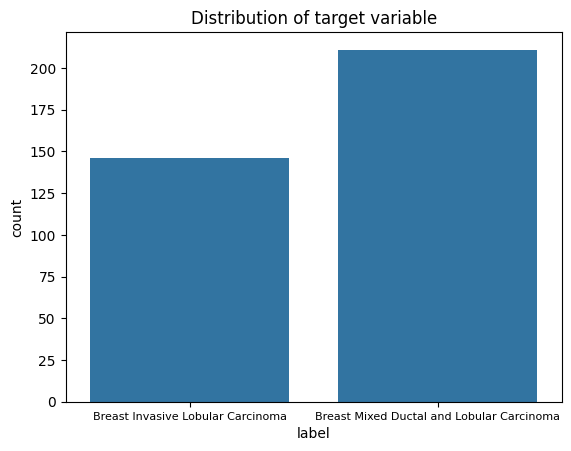

label
Breast Mixed Ductal and Lobular Carcinoma    211
Breast Invasive Lobular Carcinoma            146
Name: count, dtype: int64 
Ratio between classes: 1.45


In [ ]:
# Checking for class imbalances
sns.countplot(x='label', data=data)
plt.title('Distribution of target variable')
plt.xticks(fontsize=8)
plt.show()

label_counts = data['label'].value_counts()
print(label_counts,'\n'+'='*20)
ratio = label_counts.iloc[0] / label_counts.iloc[1]
print(f"Ratio between classes: {ratio:.2f}")

There does not seem to be a siginificant class imbalance in the data.

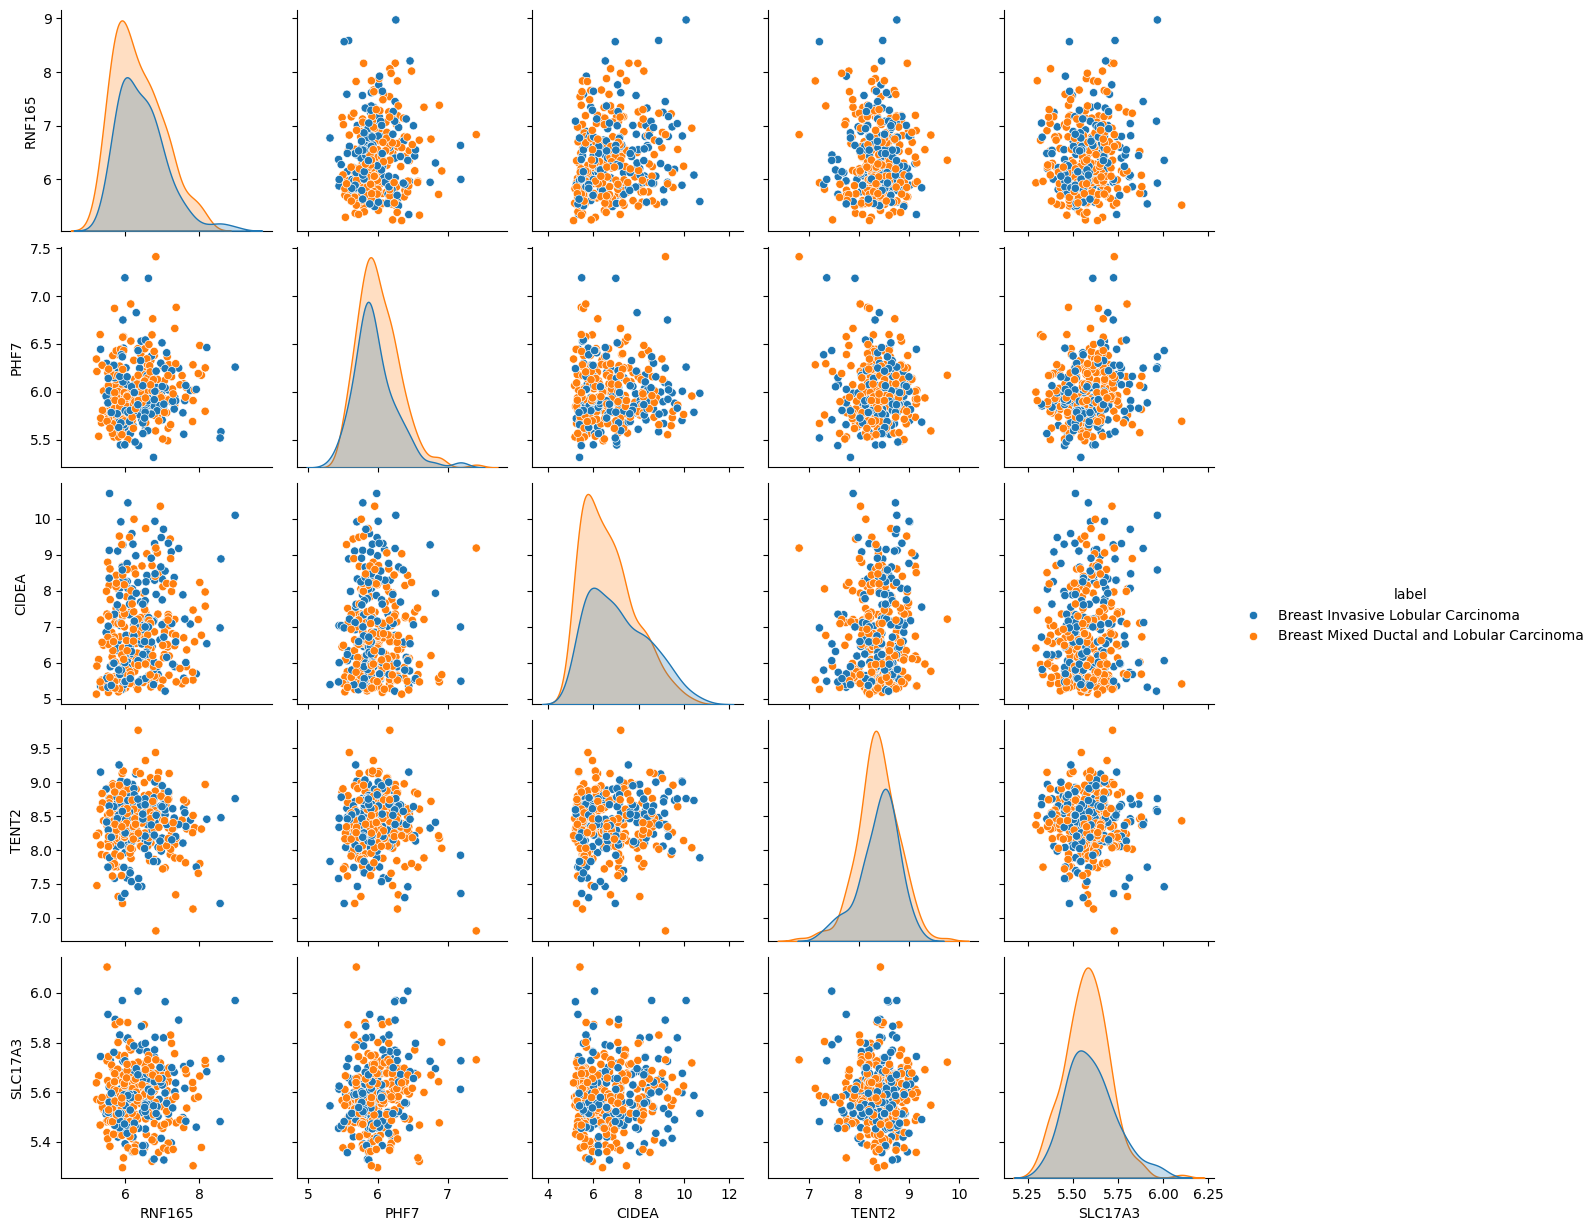

In [ ]:
# Pairplot of arbitrary genes
sns.pairplot(data=data, vars=data.columns[1:6], hue='label')
plt.show()

Dimensionality reduction using PCA:

In [ ]:
# Select numerical columns
numerical_data = data.select_dtypes(include=['number'])

# Standardize numerical data
X_raw = data.drop(['label'], axis=1)
X_scaled = StandardScaler().fit_transform(X_raw)
y = data.label

# Apply PCA
pca = PCA(n_components=2)
X = pca.fit_transform(X_scaled)
print(pca.explained_variance_ratio_)

[0.07922548 0.05152046]


The two principal components together capture only about 13% of the variance in the dataset. This means a significant portion of the information present in the original data is not represented well, and most likely more components are needed.

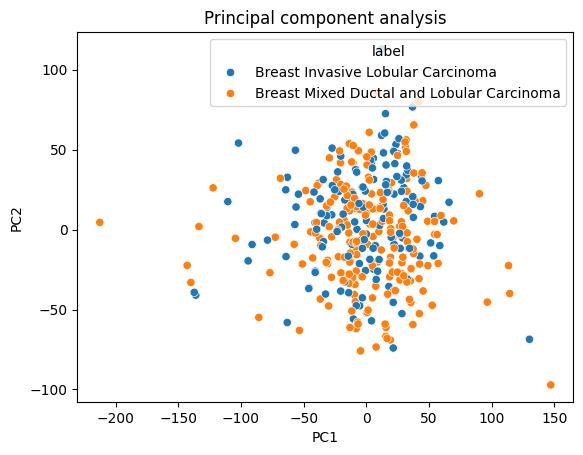

In [ ]:
# PCA visualization
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Principal component analysis")
plt.show()

The overlapping classes in the scatterplot indicate that they are not easily separable when projected onto the first two principal components (PC1 and PC2). These two principal components do not contain enough information to clearly distinguish between the two classes.

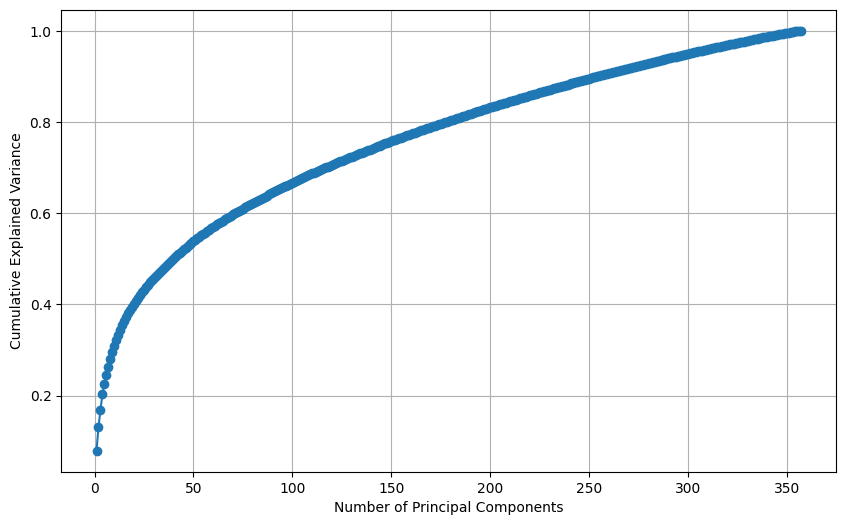

In [ ]:
# Number of PCs vs explained variance
pca = PCA().fit(X_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

**PCA and cumulative variance:**

After about 50 components the cumulative variance starts to plateau. This point suggests a good balance between explained variance and dimensionality reduction. To achieve a cumulative explained variance of 90%, we would need about 250 components.

**Feature selection:**

Alternatively, we can directly select the most important features (genes) by ranking them based on their correlation with the target variable, selecting only the top 10% to train the model. This approach loses the information present in the discarded features, but helps reduce complexity and simplify the model, potentially leading to better interpretability and preventing overfitting.

In [ ]:
# Correlations between features and target variable
label_encoder = LabelEncoder()
data['label_encoded'] = label_encoder.fit_transform(data['label'])
numerical_data = data.select_dtypes(include=['number'])
corr = numerical_data.corrwith(numerical_data['label_encoded'])
ranked_corr = corr.abs().sort_values(ascending=False)
print(ranked_corr)

label_encoded    1.000000
CDH1             0.328067
AQP1             0.301388
SPRYD3           0.291390
COL11A1          0.290534
                   ...   
ZSCAN4           0.000033
TLR7             0.000022
SH3TC1           0.000011
SLC35D2          0.000009
RHEB             0.000009
Length: 20604, dtype: float64


In [ ]:
# Removing bottom 90%
cutoff_value = ranked_corr.quantile(0.90)
selected_features = ranked_corr[ranked_corr > cutoff_value].index
filtered_data = data[['label'] + list(selected_features)]
print(filtered_data.shape)
print(filtered_data.head())

(357, 2062)
                                               label  label_encoded  \
sample_id                                                             
MB-0605            Breast Invasive Lobular Carcinoma              0   
MB-0199    Breast Mixed Ductal and Lobular Carcinoma              1   
MB-0117    Breast Mixed Ductal and Lobular Carcinoma              1   
MB-0906    Breast Mixed Ductal and Lobular Carcinoma              1   
MB-0653            Breast Invasive Lobular Carcinoma              0   

                CDH1      AQP1    SPRYD3    COL11A1    NKX3-2     PDZD2  \
sample_id                                                                 
MB-0605     8.830809  6.407473  7.922528   9.932865  6.234207  6.484498   
MB-0199    10.726223  6.293454  8.158985   9.721828  5.919964  6.347589   
MB-0117     9.638604  6.538448  8.073140   9.317723  6.262536  6.316640   
MB-0906    10.325353  6.357525  7.809484  10.389756  6.484277  6.437436   
MB-0653     7.019052  5.879663  7.485930

# Model selection and training

- Choose a few machine learning methods that seem appropriate for this classification task.
- Train and fine-tune these models using the provided data, make sure that you evaluate their
performance using the right metrics.
- Reflect on how different approaches might impact the results and why.

K-nearest neighbors classifier

In [187]:
X = filtered_data.drop(['label','label_encoded'], axis=1)
y = filtered_data['label']
X_scaled = StandardScaler().fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Apply KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # Start with k=5, tune it later
knn_model.fit(X_train, y_train)

knn_y_pred = knn_model.predict(X_test)

knn_accuracy = accuracy_score(y_test, knn_y_pred)
print("KNN accuracy:", knn_accuracy)

KNN accuracy: 0.6666666666666666


The KNN accuracy represents the proportion of correctly classified samples by the K-Nearest Neighbors (KNN) model on the test dataset.

The meaning of the accuracy value depends on the specific problem you are trying to solve. For some tasks, an accuracy of 85% might be considered excellent, while for others, it might be too low.

The accuracy of the KNN model can be influenced by the choice of the k value.

KNN Confusion Matrix

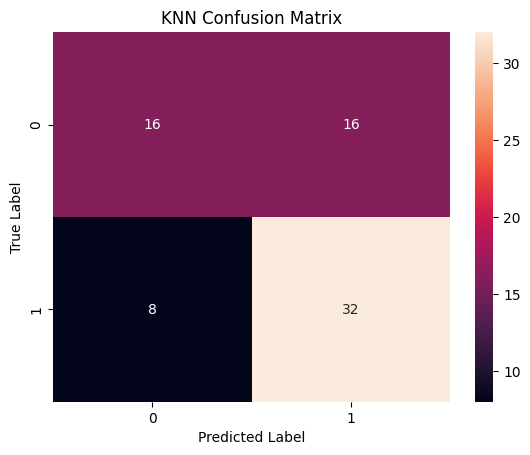

In [194]:
# For KNN:
knn_confusion_matrix = confusion_matrix(y_test, knn_y_pred)

# For KNN:
sns.heatmap(knn_confusion_matrix, annot=True, fmt="d")
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

KNN F1 Score

In [208]:
# For KNN
unique_labels = set(data['label'].unique()).union(set(y_pred))  # Include labels from y_pred
label_mapping = {label: i for i, label in enumerate(unique_labels)}  # Use label as key and index as value
y_pred_mapped = [label_mapping[pred] for pred in y_pred]
knn_f1 = f1_score(y_test.map(label_mapping), y_pred_mapped, average='weighted')  # Use weighted average for multi-class
print("KNN F1 Score:", knn_f1)

KNN F1 Score: 0.658008658008658


Linear discriminant analysis classifier

In [188]:
X = filtered_data.drop(['label','label_encoded'], axis=1)
y = filtered_data['label']
X_scaled = StandardScaler().fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Apply LDA model
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

lda_y_pred = lda_model.predict(X_test)

lda_accuracy = accuracy_score(y_test, lda_y_pred)
print("LDA Accuracy:", lda_accuracy)

LDA Accuracy: 0.7083333333333334


LDA Confusion Matrix

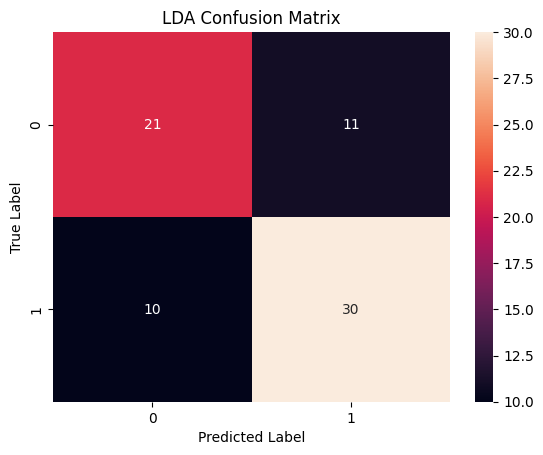

In [195]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ... (LDA model fitting and prediction code) ...

# For LDA:
lda_confusion_matrix = confusion_matrix(y_test, lda_y_pred)

# Visualize LDA Confusion Matrix
sns.heatmap(lda_confusion_matrix, annot=True, fmt="d")
plt.title("LDA Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

LDA F1 Score

In [197]:
# For LDA
from sklearn.metrics import f1_score

lda_f1 = f1_score(y_test, lda_y_pred, average='weighted')  # Or use 'macro' if needed
print("LDA F1 Score:", lda_f1)

LDA F1 Score: 0.7078189300411523


Quadratic discriminant analysis classifier

In [206]:
X = filtered_data.drop(['label','label_encoded'], axis=1)
y = filtered_data['label']
X_scaled = StandardScaler().fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Apply QDA model
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)

qda_y_pred = qda_model.predict(X_test)

qda_accuracy = accuracy_score(y_test, qda_y_pred)
print("QDA Accuracy:", qda_accuracy)

/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


QDA Accuracy: 0.4166666666666667


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


The QDA accuracy tells us how often the model is making correct predictions on unseen data.

A higher accuracy score indicates better performance, stonger generalization, improved reliability and higher confidence.

In this case the QDA is performing worse than the LDA model.

QDA Confusion Matrix

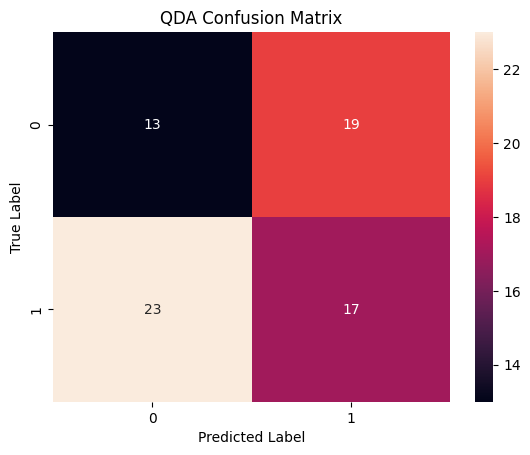

In [202]:
from sklearn.metrics import confusion_matrix

# For QDA:
qda_confusion_matrix = confusion_matrix(y_test, qda_y_pred)

# For QDA:
sns.heatmap(qda_confusion_matrix, annot=True, fmt="d")
plt.title("QDA Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

The confusion matrix of the QDA provides a breakdown of the QDA model's performance by showing the true positives, true negatives, false positives, and false negatives.

The diagonal elements show how well the QDA is performing in terms of correctly classifying samples.

The off diagonal elements show the types of errors the model is making.

The rules for the confusion matrix of the KNN hold the same for the QDA

QDA F1 Score

In [205]:
# For QDA
unique_labels_qda = set(data['label'].unique()).union(set(qda_y_pred))  # Include labels from qda_pred
label_mapping_qda = {label: i for i, label in enumerate(unique_labels_qda)} # Use label as key and index as value
qda_pred_mapped = [label_mapping_qda[pred] for pred in qda_y_pred]
qda_f1 = f1_score(y_test.map(label_mapping_qda), qda_pred_mapped, average='weighted')  # Use weighted average for multi-class
print("QDA F1 Score:", qda_f1)

QDA F1 Score: 0.41847265221878227


The F1 score is a metric that combines precision and recall into a single value. The F1 values for the KNN and QDA vare comparable, but they are not as strong as the LDA. The LDA is thus the most promising model in the dataset.

Comparisons

In [209]:
print("Accuracy Scores:")
print("KNN:", knn_accuracy)  # Assuming 'accuracy' variable from your KNN code
print("QDA:", qda_accuracy)  # Assuming 'accuracy' variable from your QDA code
print("LDA:", lda_accuracy)  # Assuming 'accuracy_test' variable from your LDA code

print("\nF1 Scores:")
print("KNN:", knn_f1)
print("QDA:", qda_f1)
print("LDA:", lda_f1)

# Confusion matrices are already visualized in your code, but you can also print them:
print("\nKNN Confusion Matrix:")
print(knn_confusion_matrix)
print("\nQDA Confusion Matrix:")
print(qda_confusion_matrix)
print("\nLDA Confusion Matrix:")
print(lda_confusion_matrix)

Accuracy Scores:
KNN: 0.6666666666666666
QDA: 0.4166666666666667
LDA: 0.7083333333333334

F1 Scores:
KNN: 0.658008658008658
QDA: 0.41847265221878227
LDA: 0.7078189300411523

KNN Confusion Matrix:
[[16 16]
 [ 8 32]]

QDA Confusion Matrix:
[[13 19]
 [23 17]]

LDA Confusion Matrix:
[[21 11]
 [10 30]]


The LDA model appears to be performing the best overall. It achieves the highest scores for both accuracy and weighted F1 score compared to the KNN and QDA.

The LDA also demonstratest a relatively better pefroamcne across both metrics, suggesting that it's a more robust and reliable model for this dataset.

The weighted F1 score is an important metric for imbalanced datasets because it shows the distribution of classes.

Cross Validation

In [212]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming 'data' is your DataFrame
X_full = data.drop(['label'], axis=1)
X_scaled = StandardScaler().fit_transform(X_full)
y = data.label

# K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds, shuffled, with random seed

# --- KNN ---
knn = KNeighborsClassifier(n_neighbors=5)
knn_scores = cross_val_score(knn, X_scaled, y, cv=kf, scoring='accuracy')
print("KNN Cross-Validation Accuracy:", knn_scores.mean())
knn_f1_scores = cross_val_score(knn, X_scaled, y, cv=kf, scoring='f1_weighted')
print("KNN Cross-Validation F1 Score:", knn_f1_scores.mean())

# --- LDA ---
lda = LinearDiscriminantAnalysis()
lda_scores = cross_val_score(lda, X_scaled, y, cv=kf, scoring='accuracy')  # Use X_scaled for LDA
print("LDA Cross-Validation Accuracy:", lda_scores.mean())
lda_f1_scores = cross_val_score(lda, X_scaled, y, cv=kf, scoring='f1_weighted')
print("LDA Cross-Validation F1 Score:", lda_f1_scores.mean())

# --- QDA ---
qda = QuadraticDiscriminantAnalysis()
qda_scores = cross_val_score(qda, X_scaled, y, cv=kf, scoring='accuracy')
print("QDA Cross-Validation Accuracy:", qda_scores.mean())
qda_f1_scores = cross_val_score(qda, X_scaled, y, cv=kf, scoring='f1_weighted')
print("QDA Cross-Validation F1 Score:", qda_f1_scores.mean())

KNN Cross-Validation Accuracy: 0.6079029733959312
KNN Cross-Validation F1 Score: 0.5999515554432966
LDA Cross-Validation Accuracy: 0.6641627543035994
LDA Cross-Validation F1 Score: 0.6498280874640253


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

QDA Cross-Validation Accuracy: 0.44827856025039126


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

QDA Cross-Validation F1 Score: 0.44443100305551086


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


The LDA model appears to be performing the best overall. It achieves the highest scores for both accuracy and weighted F1 score compared to the KNN and QDA.

The LDA also demonstratest a relatively better pefroamcne across both metrics, suggesting that it's a more robust and reliable model for this dataset.

The weighted F1 score is an important metric for imbalanced datasets because it shows the distribution of classes.

Dummy classifier

In [213]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

X = data.drop('label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dummy_classifier = DummyClassifier(strategy="most_frequent")

dummy_classifier.fit(X_train, y_train)

y_pred = dummy_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use weighted average for multi-class

print("Dummy Classifier Accuracy:", accuracy)
print("Dummy Classifier F1 Score:", f1)

Dummy Classifier Accuracy: 0.5555555555555556
Dummy Classifier F1 Score: 0.39682539682539686


Best K value KNN

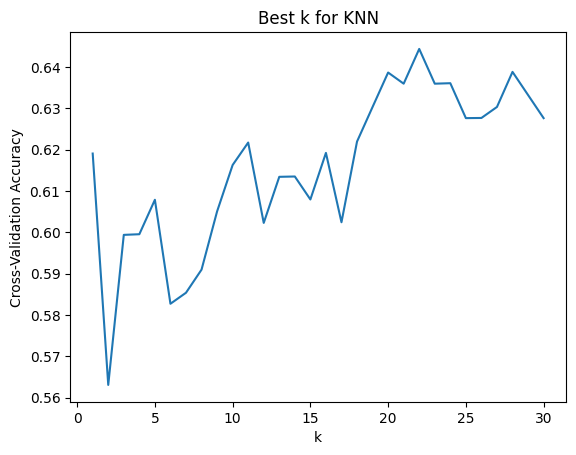

Best k: 22


In [215]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler  # Add StandardScaler

X = data.drop(['label'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_values = range(1, 31)
cv_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, y, cv=kf, scoring='accuracy')
    cv_scores.append(scores.mean())

plt.plot(k_values, cv_scores)
plt.xlabel('k')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Best k for KNN')
plt.show()

# Find the k with the highest accuracy
best_k = k_values[cv_scores.index(max(cv_scores))]
print(f"Best k: {best_k}")

# Evaluation and comparison:

**LDA:**

This code is applying Linear Discriminant Analysis (LDA) for classification.



X_full: Extracts all features except the target label.

StandardScaler().fit_transform(X_full): Scales the features to standardize them.

y = data.label: Extracts the target variable (class labels).


Splits data into:

* 80% training (X_train, y_train)

* 20% testing (X_test, y_test)

random_state=42 to ensures reproducibility.



Creates an LDA model for classification.

Fits the LDA model to the training data.

Predicts class labels for the test data.



accuracy_score(y_test, lda_pred): Computes the classification accuracy.